# Dataset loading, training and experiments



In this notebook we will load data, run trainings and we will look at experiments with trained models.

Denoising on picture below was done for the project checkpoint. In this notebook, we will not do grayscale noise removal anymore, but it is still possible by changing the variable in initialization method.

**FIRST ROW IS DENOISED**  
**SECOND ROW IS NOISED**  
**THIRD ROW IS ORIGINAL**

<img src="Pictures/1000_pictures.PNG">

# Implementation

In [2]:
import tensorflow.keras as keras
import tensorflow.keras.layers as KL
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Sequential
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from zipfile import ZipFile

%load_ext autoreload
%autoreload 2

%matplotlib notebook

%load_ext tensorboard
%tensorboard --logdir logs --bind_all

sys.path.append('..')

Reusing TensorBoard on port 6006 (pid 272), started 0:18:28 ago. (Use '!kill 272' to kill it.)

In [3]:
artifact_encoder = None;

### Current implementation is set to rgb denoising, by changing `rgb_or_grayscale` to `1` will change it to grayscale denoising

In [4]:
class Constants:
    IMG_SIZE = 64 
    NUM_OF_PICTURES = 1000
    RGB_OR_GRAYSCALE = 3 # 1 for grayscale, 3 for rgb
    train_orig = []
    test_orig = []
    train_noised = []
    test_noised = []
    autoencoder = None

In [5]:
def set_initialization_variables(img_size, num_of_pictures, rgb_or_grayscale):
    train_orig = []
    test_orig = []
    train_noised = []
    test_noised = []
    Constants.IMG_SIZE = img_size 
    Constants.NUM_OF_PICTURES = num_of_pictures
    Constants.RGB_OR_GRAYSCALE = rgb_or_grayscale #3 # 1 for grayscale, 3 for rgb

#### We load rgb pictures and by constant RGB_OR_GRAYSCALE we determine if the model will be trained on rgb or grayscale images

In [6]:
def load_images(orig_path, changed_path):
    mypath_orig = orig_path
    mypath_noised = changed_path

    onlyfiles_orig = [f for f in listdir(mypath_orig) if isfile(join(mypath_orig, f))]
    onlyfiles_noised = [f for f in listdir(mypath_noised) if isfile(join(mypath_noised, f))]

    original_images = np.empty([Constants.NUM_OF_PICTURES,Constants.IMG_SIZE, Constants.IMG_SIZE, Constants.RGB_OR_GRAYSCALE])
    noised_images = np.empty([Constants.NUM_OF_PICTURES,Constants.IMG_SIZE, Constants.IMG_SIZE, Constants.RGB_OR_GRAYSCALE])

    iterationOrig = 0
    iterationNoised = 0
    print(onlyfiles_orig[1])
    for q in onlyfiles_orig[:Constants.NUM_OF_PICTURES]:
        name = mypath_orig +"/"+q
        original_images[iterationOrig] = image.img_to_array(image.load_img(name, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))
        original_images[iterationOrig] /= 255.0

        path = mypath_noised +"/"+ q
        noised_images[iterationOrig] = image.img_to_array(image.load_img(path, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))
        noised_images[iterationOrig] /= 255.0
        iterationOrig += 1
        
    split = int(Constants.NUM_OF_PICTURES*0.7)

    Constants.train_orig = original_images[:split]
    Constants.test_orig = original_images[split:]

    Constants.train_noised = noised_images[:split]
    Constants.test_noised = noised_images[split:]

In [7]:
def show_image_in_plot(ax, img):
    if Constants.RGB_OR_GRAYSCALE == 1:
        ax.imshow(img[:,:,1])
    elif Constants.RGB_OR_GRAYSCALE == 3:
        ax.imshow(img[:,:,:])

In [8]:
def show_loaded_images():
    imgs = Constants.test_noised[:4]
    _, axs = plt.subplots(2, 2, figsize=(4, 4))
    axs = axs.flatten()
    plt.gray()
    for img, ax in zip(imgs, axs):
        show_image_in_plot(ax, img)
        #ax.imshow(img[:,:,:])
    plt.show()  

    imgs = Constants.test_orig[:4]
    _, axs = plt.subplots(2, 2, figsize=(4, 4))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        show_image_in_plot(ax, img)
        #ax.imshow(img[:,:,:])
    plt.show()

#### Architecture is the same as in the description at the top of file

For a hyper-parameter tunning, we have used these lambdas and trained the model multiple times with random values

```py
batch_size_lambda = lambda: np.random.randint(1, 20)
optimizers = [keras.optimizers.Adam(), keras.optimizers.Adadelta(), keras.optimizers.Adagrad(),
             keras.optimizers.SGD(), keras.optimizers.RMSprop()]
loss_functions = [keras.losses.categorical_crossentropy, keras.losses.mse, 
                 keras.losses.msle]
activations = ["sigmoid", "tanh", "relu", "softmax"]

optimizers_lambda = lambda: np.random.randint(0, len(optimizers)-1)
loss_lambda = lambda: np.random.randint(0, len(loss_functions)-1)
activations_lambda = lambda: np.random.randint(0, len(activations)-1)
```


In [9]:
def train(number_of_trainings, model_file="autoencoder_rgb.hdf5"):
    for i in range(number_of_trainings):
        input_img = Input(shape=(Constants.IMG_SIZE, Constants.IMG_SIZE, Constants.RGB_OR_GRAYSCALE))

        d1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(d1)
        x = BatchNormalization()(x)
        d2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(d2)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(64, (2, 2), activation='relu', padding='same')(encoded)
        x = BatchNormalization()(x)

        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2, 2))(x)

        x = concatenate([x,d1,d2])
        
        decoded = Conv2D(Constants.RGB_OR_GRAYSCALE, (3, 3), activation="sigmoid", padding='same')(x)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer=keras.optimizers.Adam(), loss='mse')

        dt =  datetime.now()
        current_timestamp = str(dt.year) + '-' + str(dt.month) + '-' + str(dt.day) + '-' + str(dt.hour) + '-' + str(dt.minute)

        print(Constants.train_orig.shape)
        print(Constants.test_orig.shape)
        print(Constants.train_noised.shape)
        print(Constants.test_noised.shape)

        early_stopping = EarlyStopping(patience=5, verbose=1, monitor="val_loss")
        model_checkpoint = ModelCheckpoint(f"./{model_file}", monitor="val_loss", save_best_only=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(factor=0.1, patience=7, min_lr=0.00001, verbose = 1, monitor = "val_loss")
        autoencoder.fit(Constants.train_noised, Constants.train_orig,
                        epochs=30,
                        batch_size=10,
                        shuffle=True,
                        validation_data=(Constants.test_noised, Constants.test_orig),
                        callbacks=[model_checkpoint, 
                                   early_stopping, 
                                   reduce_lr, 
                                   keras.callbacks.TensorBoard(
                                       log_dir=os.path.join("logs", current_timestamp + "_final"),
                                       histogram_freq=1,
                                       profile_batch=0)]
                       )
        
        return autoencoder

In [10]:
def predict(autoencoder):
    count = 4
    start = np.random.randint(0, Constants.NUM_OF_PICTURES*0.3 - count)

    print(start)
    imgs = Constants.test_noised[start:start+count]
    imgs = np.concatenate((imgs, Constants.test_noised[start:start+count], Constants.test_orig[start:start+count]))
    
    _, axs = plt.subplots(3, count, figsize=(10, 10))

    axs = axs.flatten()
    i = 0
    for img, ax in zip(imgs, axs):
        if (i < count):
            p_img = autoencoder.predict(img[np.newaxis,:,:,:])[0,:,:,:]
            show_image_in_plot(ax, p_img)
            #ax.imshow(p_img[:,:,:])
        else:
            show_image_in_plot(ax, img)
            #ax.imshow(img[:,:,:])
        i+=1
    plt.show()   


## Running test and validations

In [11]:
def unzip(path_to_zip_file):
    folder_name = "." + path_to_zip_file.split(".")[1]

    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
        with ZipFile(path_to_zip_file, 'r') as zip_ref:
            zip_ref.extractall(folder_name)
            
    return folder_name

In [12]:
def get_directories(path_to_zip_file):
    folder_name = unzip(path_to_zip_file)
    directories = []
    for root, _directories, _ in os.walk(folder_name):
        for directory in _directories:
            directories.append(root + "/"+ directory)
        break

    return directories

## Artifacts removal training

In [65]:
path_to_zip_file = "./noise_generation/artifacts.zip" 
set_initialization_variables(img_size=64, num_of_pictures=10000, rgb_or_grayscale=3)

directories = get_directories(path_to_zip_file);    

if "orig" in directories[0]:
    load_images(directories[0], directories[1])
elif "changed" in directories[0]:
    load_images(directories[1], directories[0])
else:
    raise Exception("Folders of noised and orig are badly named or placed")

print(directories[1], directories[0], "--> OK")


000000402346.jpg
./noise_generation/artifacts/artifacts_changed ./noise_generation/artifacts/artifacts_orig --> OK


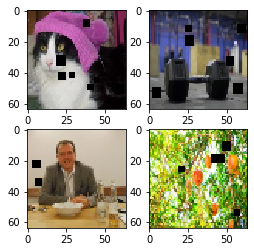

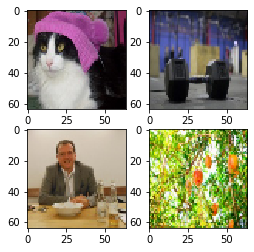

In [66]:
show_loaded_images()

In [67]:
artifacts_autoencoder = train(number_of_trainings=1, model_file="artifacts.hdf5")  # num_of_training is now 1, because we already know best params

(7000, 64, 64, 3)
(3000, 64, 64, 3)
(7000, 64, 64, 3)
(3000, 64, 64, 3)
Train on 7000 samples, validate on 3000 samples
Epoch 1/30
6990/7000 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 00001: val_loss improved from inf to 0.00155, saving model to ./artifacts.hdf5
7000/7000 [==============================] - 37s 5ms/sample - loss: 0.0047 - val_loss: 0.0016
Epoch 2/30
6990/7000 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 00002: val_loss improved from 0.00155 to 0.00121, saving model to ./artifacts.hdf5
7000/7000 [==============================] - 34s 5ms/sample - loss: 0.0019 - val_loss: 0.0012
Epoch 3/30
6990/7000 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00003: val_loss did not improve from 0.00121
7000/7000 [==============================] - 34s 5ms/sample - loss: 0.0013 - val_loss: 0.0016
Epoch 4/30
6990/7000 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00004: val_loss improved from 0.00121 to 0.00096, s

2036


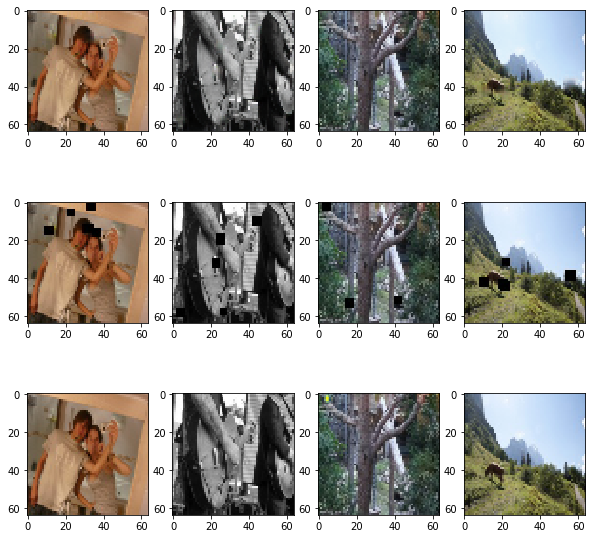

In [68]:
artifact_encoder = artifacts_autoencoder
predict(artifacts_autoencoder)


As we can see, artifact removal is working, but when the artifact covers edges or parts of different objects, the neural network could not predict how to repair it. In order to work on such scenarios, we would have to implement GAN so it will fix images according to object context.

## Resize artifacts removal training

In [69]:
path_to_zip_file = "./noise_generation/resized_images.zip" 
set_initialization_variables(img_size=64, num_of_pictures=10000, rgb_or_grayscale=3)

directories = get_directories(path_to_zip_file);    

if "orig" in directories[0]:
    load_images(directories[0], directories[1])
elif "changed" in directories[0]:
    load_images(directories[1], directories[0])
else:
    raise Exception("Folders of noised and orig are badly named or placed")

print(directories[1], directories[0], "--> OK")


000000402346.jpg
./noise_generation/resized_images/resized_changed ./noise_generation/resized_images/resized_orig --> OK


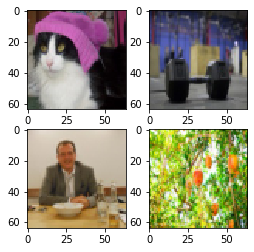

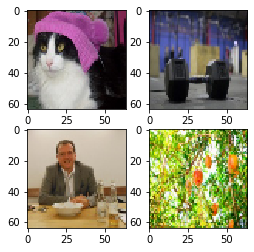

In [70]:
show_loaded_images()

In [71]:
resize_autoencoder = train(number_of_trainings=1, model_file="resized.hdf5")  # num_of_training is now 1, because we already know best params

(7000, 64, 64, 3)
(3000, 64, 64, 3)
(7000, 64, 64, 3)
(3000, 64, 64, 3)
Train on 7000 samples, validate on 3000 samples
Epoch 1/30
6980/7000 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 00001: val_loss improved from inf to 0.00271, saving model to ./resized.hdf5
7000/7000 [==============================] - 37s 5ms/sample - loss: 0.0045 - val_loss: 0.0027
Epoch 2/30
6980/7000 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 00002: val_loss did not improve from 0.00271
7000/7000 [==============================] - 34s 5ms/sample - loss: 0.0026 - val_loss: 0.0030
Epoch 3/30
6990/7000 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 00003: val_loss did not improve from 0.00271
7000/7000 [==============================] - 34s 5ms/sample - loss: 0.0021 - val_loss: 0.0029
Epoch 4/30
6990/7000 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00004: val_loss improved from 0.00271 to 0.00172, saving model to ./resized.hdf5
7000/7000 

1749


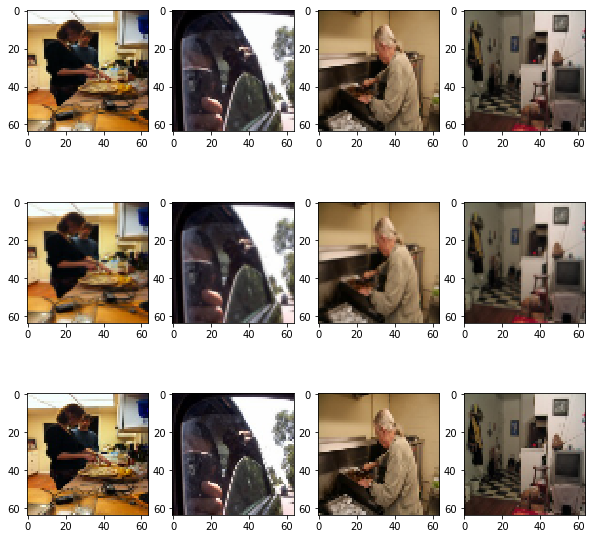

In [72]:
artifact_encoder = resize_autoencoder
predict(resize_autoencoder)

Network learnt how to sharpen the image. Final validation loss of 0.0014 is good. In experiments part we will run this model on different resize shapes.

## Chroma noise removal training

In [76]:
path_to_zip_file = "./noise_generation/noised_images.zip" 
set_initialization_variables(img_size=64, num_of_pictures=10000, rgb_or_grayscale=3)

directories = get_directories(path_to_zip_file);    

if "orig" in directories[0]:
    load_images(directories[0], directories[1])
elif "changed" in directories[0]:
    load_images(directories[1], directories[0])
else:
    raise Exception("Folders of noised and orig are badly named or placed")

print(directories[1], directories[0], "--> OK")


000000402346.jpg
./noise_generation/noised_images/noised_orig ./noise_generation/noised_images/noised_changed --> OK


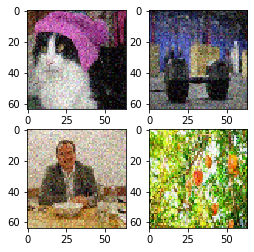

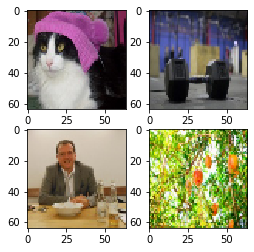

In [77]:
show_loaded_images()

In [78]:
noise_autoencoder = train(number_of_trainings=1, model_file="noised.hdf5")  # num_of_training is now 1, because we already know best params

(7000, 64, 64, 3)
(3000, 64, 64, 3)
(7000, 64, 64, 3)
(3000, 64, 64, 3)
Train on 7000 samples, validate on 3000 samples
Epoch 1/30
6980/7000 [============================>.] - ETA: 0s - loss: 0.0050
Epoch 00001: val_loss improved from inf to 0.00320, saving model to ./noised.hdf5
7000/7000 [==============================] - 37s 5ms/sample - loss: 0.0050 - val_loss: 0.0032
Epoch 2/30
6980/7000 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 00002: val_loss improved from 0.00320 to 0.00281, saving model to ./noised.hdf5
7000/7000 [==============================] - 34s 5ms/sample - loss: 0.0029 - val_loss: 0.0028
Epoch 3/30
6980/7000 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 00003: val_loss improved from 0.00281 to 0.00256, saving model to ./noised.hdf5
7000/7000 [==============================] - 34s 5ms/sample - loss: 0.0024 - val_loss: 0.0026
Epoch 4/30
6990/7000 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 00004: val_loss improv

2732


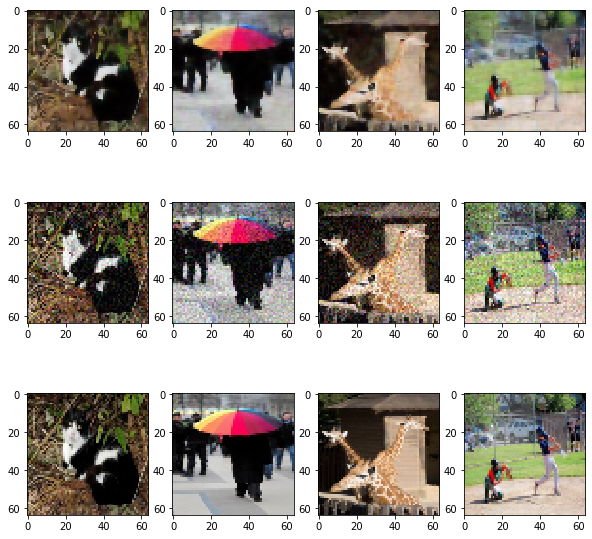

In [79]:
artifact_encoder = noise_autoencoder
predict(noise_autoencoder)

## Salt & pepper noise removal training

In [80]:
path_to_zip_file = "./noise_generation/salt_and_pepper.zip" 
set_initialization_variables(img_size=64, num_of_pictures=10000, rgb_or_grayscale=3)

directories = get_directories(path_to_zip_file);    

if "orig" in directories[0]:
    load_images(directories[0], directories[1])
elif "changed" in directories[0]:
    load_images(directories[1], directories[0])
else:
    raise Exception("Folders of noised and orig are badly named or placed")

print(directories[1], directories[0], "--> OK")


000000402346.jpg
./noise_generation/salt_and_pepper/s&p_orig ./noise_generation/salt_and_pepper/s&p_changed --> OK


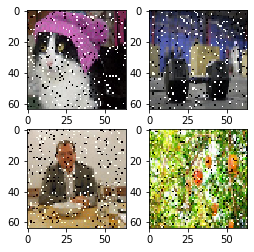

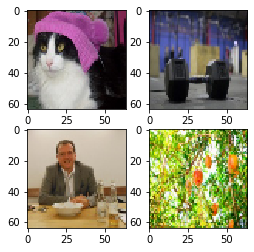

In [81]:
show_loaded_images()

In [82]:
sap_autoencoder = train(number_of_trainings=1, model_file="sap.hdf5")  # num_of_training is now 1, because we already know best params

(7000, 64, 64, 3)
(3000, 64, 64, 3)
(7000, 64, 64, 3)
(3000, 64, 64, 3)
Train on 7000 samples, validate on 3000 samples
Epoch 1/30
6990/7000 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 00001: val_loss improved from inf to 0.00255, saving model to ./sap.hdf5
7000/7000 [==============================] - 36s 5ms/sample - loss: 0.0049 - val_loss: 0.0025
Epoch 2/30
6990/7000 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 00002: val_loss improved from 0.00255 to 0.00181, saving model to ./sap.hdf5
7000/7000 [==============================] - 34s 5ms/sample - loss: 0.0020 - val_loss: 0.0018
Epoch 3/30
6980/7000 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00003: val_loss improved from 0.00181 to 0.00127, saving model to ./sap.hdf5
7000/7000 [==============================] - 34s 5ms/sample - loss: 0.0015 - val_loss: 0.0013
Epoch 4/30
6980/7000 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00004: val_loss improved from 0

1365


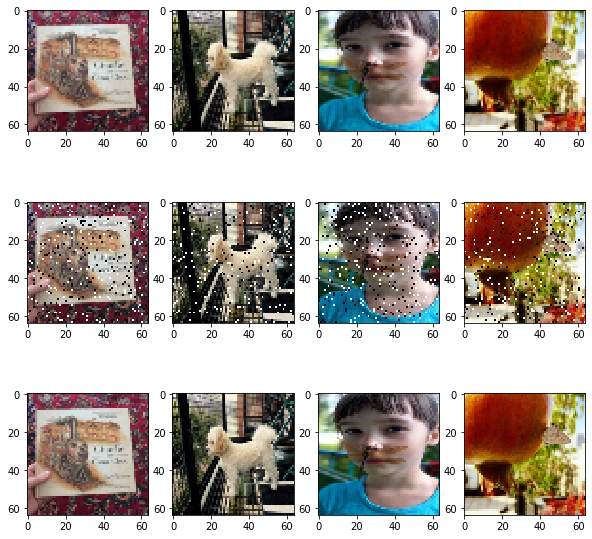

In [83]:
artifact_encoder = sap_autoencoder
predict(sap_autoencoder)

## Experiments

We will try to run resizing autoencoder on a bit different problem. We will resize images using a function with different ratio of scaling than we used in data generation. We can see that resize_autoencoder can handle this problem too, but with higher visible loss. It could not handle resize in larger ratio than we used in data generation.

0


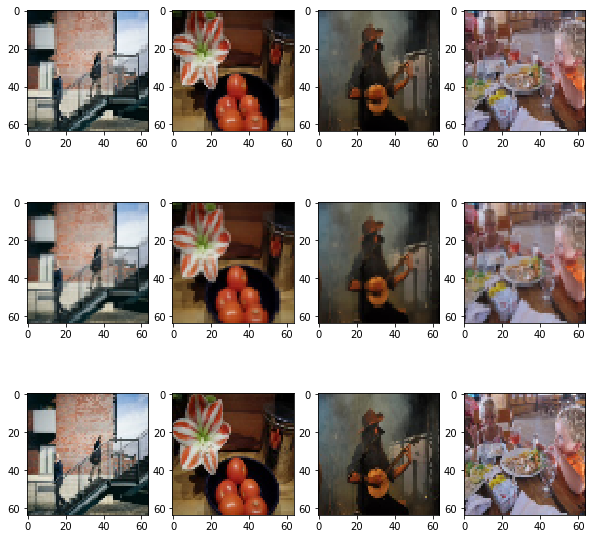

In [123]:
from skimage import transform

def resize_more(img):
    small = transform.resize(img, output_shape=(53,53))
    return transform.resize(small, (64,64), cv2.INTER_NEAREST )

process_images = []
original_images = []
Constants.NUM_OF_PICTURES = 50

for root,dir,files in os.walk("./noise_generation/original_images"):
    for file in files[:50]:
        process_images.append(resize_more(image.img_to_array(image.load_img(root+"/"+file, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))/255.0))
        original_images.append(image.img_to_array(image.load_img(root+"/"+file, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))/255.0)
        
Constants.test_noised = process_images
Constants.test_orig = original_images


predict(resize_autoencoder)

In this experiment, we will run chroma noise autoencoder on salt and pepper noise. This type of problem could not be handled by the autoencoder, which is OK because it was not trained on this type of noise.

000000402346.jpg
./noise_generation/salt_and_pepper/s&p_orig ./noise_generation/salt_and_pepper/s&p_changed --> OK
2614


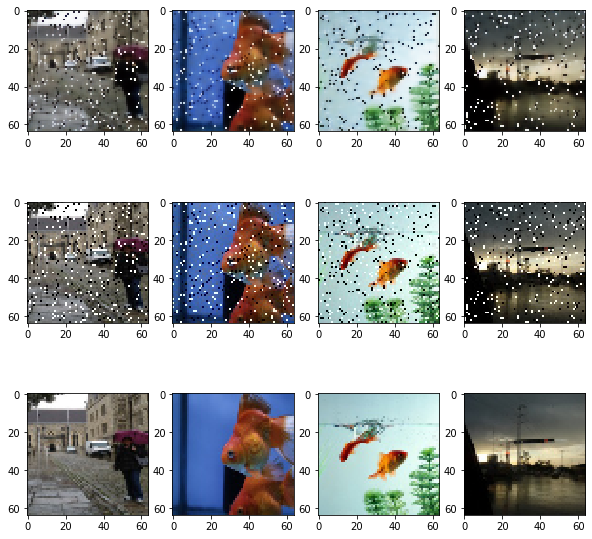

In [153]:
path_to_zip_file = "./noise_generation/salt_and_pepper.zip" 

directories = get_directories(path_to_zip_file);    

if "orig" in directories[0]:
    load_images(directories[0], directories[1])
elif "changed" in directories[0]:
    load_images(directories[1], directories[0])
else:
    raise Exception("Folders of noised and orig are badly named or placed")

print(directories[1], directories[0], "--> OK")

predict(noise_autoencoder)

We add a Gaussian noise too. Autoencoder is actually making it less noised. This is because Gaussian noise and Chroma noise are similar. When we add a gaussian blur with lower sigma, it is handled better.

9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


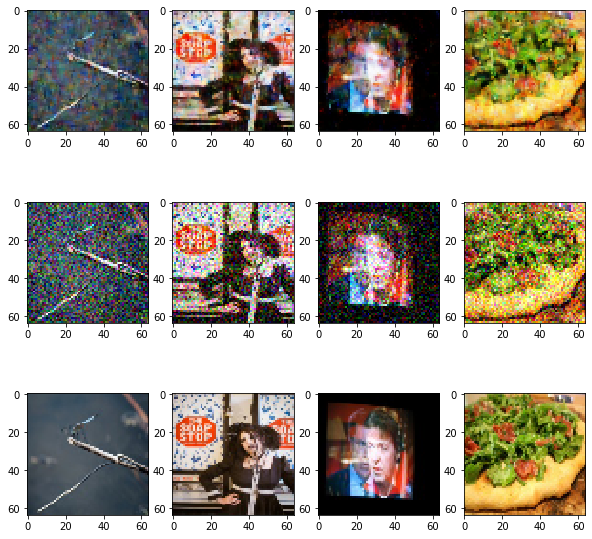

In [150]:
def add_gaussian_noise(img):
    row,col,ch= img.shape
    mean = 0
    var = 0.05
    sigma = var**0.58
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = img + gauss
    return noisy


process_images = []
original_images = []

for root,dir,files in os.walk("./noise_generation/original_images"):
    for file in files[:50]:
        process_images.append(add_gaussian_noise(image.img_to_array(image.load_img(root+"/"+file, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))/255.0))
        original_images.append(image.img_to_array(image.load_img(root+"/"+file, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))/255.0)
        
Constants.test_noised = process_images
Constants.test_orig = original_images

predict(noise_autoencoder)

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


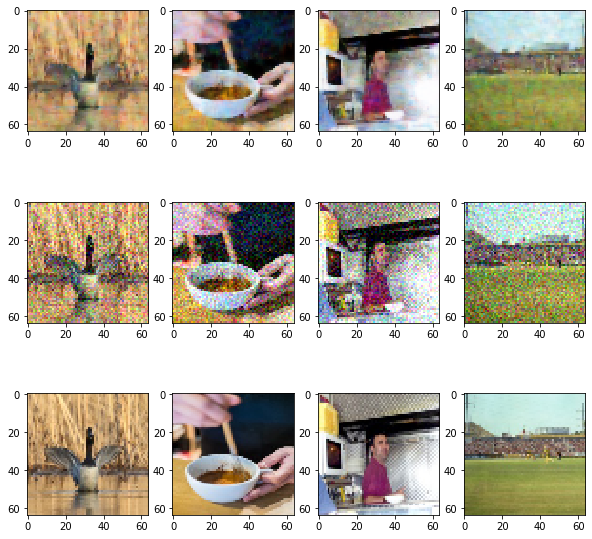

In [152]:
def add_gaussian_noise_weaker(img):
    row,col,ch= img.shape
    mean = 0
    var = 0.05
    sigma = var**0.7
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = img + gauss
    return noisy

process_images = []
original_images = []

for root,dir,files in os.walk("./noise_generation/original_images"):
    for file in files[50:100]:
        process_images.append(add_gaussian_noise_weaker(image.img_to_array(image.load_img(root+"/"+file, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))/255.0))
        original_images.append(image.img_to_array(image.load_img(root+"/"+file, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))/255.0)
        
Constants.test_noised = process_images
Constants.test_orig = original_images

predict(noise_autoencoder)

In last experiment, we will add more random shapes to image and run artifacts removal network. Results are pretty well. However, an important discovery is, that when we add artifacts of different size (for example from 5 to 10, not from 4 to 7), network is not able to remove these artifacts. It is completely ignoring them. This is because it was trained to remove these sizes only.

10


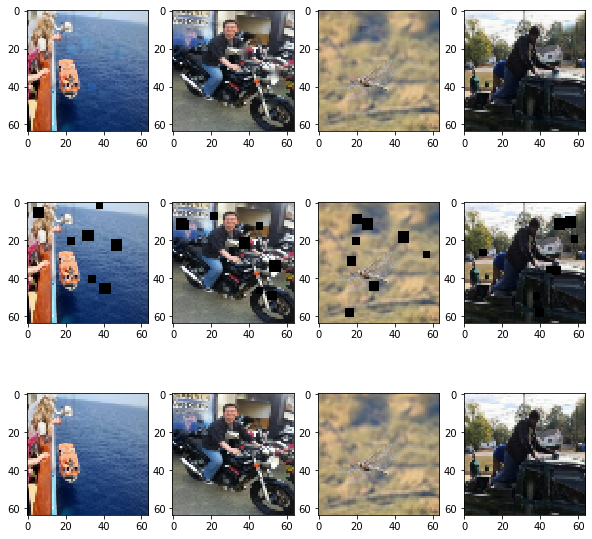

In [173]:
from skimage.draw import random_shapes

def add_artifact(img):
    max_artifact_size = 7
    size = np.random.randint(4,max_artifact_size)
    res, labels = random_shapes((size, size), max_shapes=1, shape='rectangle',multichannel=True)
    x_offset=np.random.randint(0, img.shape[0]-max_artifact_size)
    y_offset=np.random.randint(0, img.shape[0]-max_artifact_size)
    new_img = np.copy(img)
    new_img[y_offset:y_offset+res.shape[0], x_offset:x_offset+res.shape[1]] = res*0
    return new_img

def apply_artifacts(img):
    number_of_artifacts = 8
    for i in range(number_of_artifacts):
        img = add_artifact(img)
        
    return img

Constants.NUM_OF_PICTURES = 50
process_images = []
original_images = []

for root,dir,files in os.walk("./noise_generation/original_images"):
    for file in files[200:250]:
        process_images.append(apply_artifacts(image.img_to_array(image.load_img(root+"/"+file, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))/255.0))
        original_images.append(image.img_to_array(image.load_img(root+"/"+file, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))/255.0)
        
Constants.test_noised = process_images
Constants.test_orig = original_images

predict(artifacts_autoencoder)

We can see that artifacts from the size range the network was trained on are removed, however smaller artifacts are ignored.

10


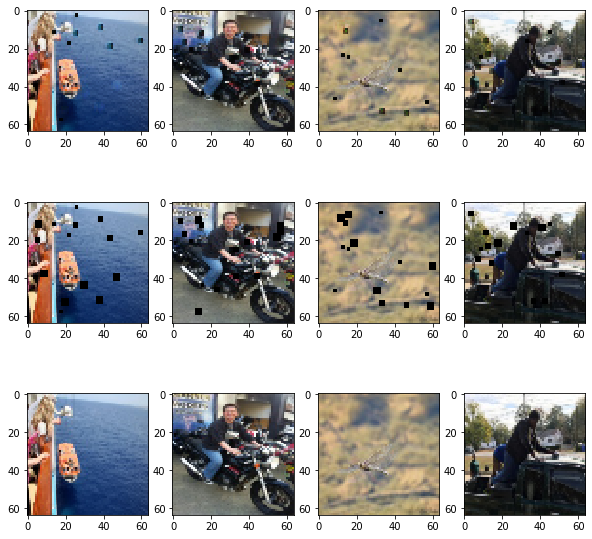

In [175]:
from skimage.draw import random_shapes

def add_artifact_smaller(img):
    max_artifact_size = 5
    size = np.random.randint(2,max_artifact_size)
    res, labels = random_shapes((size, size), max_shapes=1, shape='rectangle',multichannel=True)
    x_offset=np.random.randint(0, img.shape[0]-max_artifact_size)
    y_offset=np.random.randint(0, img.shape[0]-max_artifact_size)
    new_img = np.copy(img)
    new_img[y_offset:y_offset+res.shape[0], x_offset:x_offset+res.shape[1]] = res*0
    return new_img

def apply_artifacts_smaller(img):
    number_of_artifacts = 15
    for i in range(number_of_artifacts):
        img = add_artifact_smaller(img)
        
    return img

Constants.NUM_OF_PICTURES = 50
process_images = []
original_images = []

for root,dir,files in os.walk("./noise_generation/original_images"):
    for file in files[200:250]:
        process_images.append(apply_artifacts_smaller(image.img_to_array(image.load_img(root+"/"+file, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))/255.0))
        original_images.append(image.img_to_array(image.load_img(root+"/"+file, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))/255.0)
        
Constants.test_noised = process_images
Constants.test_orig = original_images

predict(artifacts_autoencoder)